In [177]:
import os
import sys
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mplimage
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import matplotlib.collections as mplcollections
import matplotlib.colors as mplcolors
import matplotlib.transforms as mpltransforms
from scipy.stats import gaussian_kde, linregress

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle
ccycle = cosmostyle.color_cycle

In [178]:
def cc(x, p):
    return np.dot(p-p.mean(), x-x.mean())/(np.std(p)*np.std(x)*len(p))

def load_framework_data(filename):
    framework_energies = []
    framework_volumes = []
    structure_idxs = []
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split()
            structure_idxs.append(int(data[7]))
            framework_volumes.append(float(data[8]))
            framework_energies.append(float(data[9]))

    framework_energies = np.asarray(framework_energies)
    framework_volumes = np.asarray(framework_volumes)
    structure_idxs = np.asarray(structure_idxs)

    s, ss, sc = np.unique(structure_idxs, return_counts=True, return_index=True)
    framework_volumes = 3*framework_volumes[ss]/sc #####
    framework_energies = framework_energies[ss]*sc
    framework_energies -= np.mean(framework_energies/(sc*3))*(sc*3)
    framework_energies /= sc
    
    return framework_volumes, framework_energies, structure_idxs

def build_ellipse(v, e, ax, s=1, **kwargs):
    c = s*np.cov(v, e)
    p = c[0, 1]/(np.sqrt(c[0, 0])*np.sqrt(c[1, 1]))
    v_mean = np.mean(v)
    e_mean = np.mean(e)
    
    w = 2*np.sqrt(1+p)
    h = 2*np.sqrt(1-p)
    E = mplpatches.Ellipse(xy=(0, 0), width=w, height=h, angle=0, **kwargs)
    scale_w = np.sqrt(c[0, 0])
    scale_h = np.sqrt(c[1, 1])
    transf = mpltransforms.Affine2D().rotate_deg(45).scale(scale_w, scale_h).translate(v_mean, e_mean)
    E.set_transform(transf + ax.transData)
   
    return E

# Correlation Plots

Be sure to note that there may be outliers that don't show up in the KDE!

## 1k Data

In [179]:
kpca_1k_6A = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')
volumes_1k_6A = np.loadtxt('../Processed_Data/DEEM_1k/Volume/6.0/Gaussian/envProperties-0.dat')*3 # Normalize per Si atom
energies_1k_6A = np.loadtxt('../Processed_Data/DEEM_1k/Energy/6.0/Gaussian/envProperties-0.dat')

kpca_1k_3A = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')
volumes_1k_3A = np.loadtxt('../Processed_Data/DEEM_1k/Volume/3.5/Gaussian/envProperties-0.dat')*3 # Normalize per Si atom
energies_1k_3A = np.loadtxt('../Processed_Data/DEEM_1k/Energy/3.5/Gaussian/envProperties-0.dat')

angles_1k = np.loadtxt('../Processed_Data/DEEM_1k/Angles/angles.dat')
distances_1k = np.loadtxt('../Processed_Data/DEEM_1k/Distances/distances.dat')

In [180]:
var3 = kpca_1k_3A.var(axis=0)
var6 = kpca_1k_6A.var(axis=0)
varA = angles_1k.var(axis=0)
varD = distances_1k.var(axis=0)

ccV3 = np.zeros(len(var3))
ccV6 = np.zeros(len(var6))
ccE3 = np.zeros(len(var3))
ccE6 = np.zeros(len(var6))

ccAV3 = np.zeros(len(varA))
ccAV6 = np.zeros(len(varA))
ccAE3 = np.zeros(len(varA))
ccAE6 = np.zeros(len(varA))
ccDV3 = np.zeros(len(varD))
ccDV6 = np.zeros(len(varD))
ccDE3 = np.zeros(len(varD))
ccDE6 = np.zeros(len(varD))

for i in range(0, kpca_1k_3A.shape[1]):
    ccE3[i] = cc(kpca_1k_3A[:, i], energies_1k_3A)
    ccV3[i] = cc(kpca_1k_3A[:, i], volumes_1k_3A)
    
for i in range(0, kpca_1k_6A.shape[1]):    
    ccE6[i] = cc(kpca_1k_6A[:, i], energies_1k_6A)
    ccV6[i] = cc(kpca_1k_6A[:, i], volumes_1k_6A)
    
for i in range(0, angles_1k.shape[1]):
    ccAE3[i] = cc(angles_1k[:, i], energies_1k_3A)
    ccAE6[i] = cc(angles_1k[:, i], energies_1k_6A)
    ccAV3[i] = cc(angles_1k[:, i], volumes_1k_3A)
    ccAV6[i] = cc(angles_1k[:, i], volumes_1k_6A)
    
for i in range(0, distances_1k.shape[1]):    
    ccDE3[i] = cc(distances_1k[:, i], energies_1k_3A)
    ccDE6[i] = cc(distances_1k[:, i], energies_1k_6A)
    ccDV3[i] = cc(distances_1k[:, i], volumes_1k_3A)
    ccDV6[i] = cc(distances_1k[:, i], volumes_1k_6A)

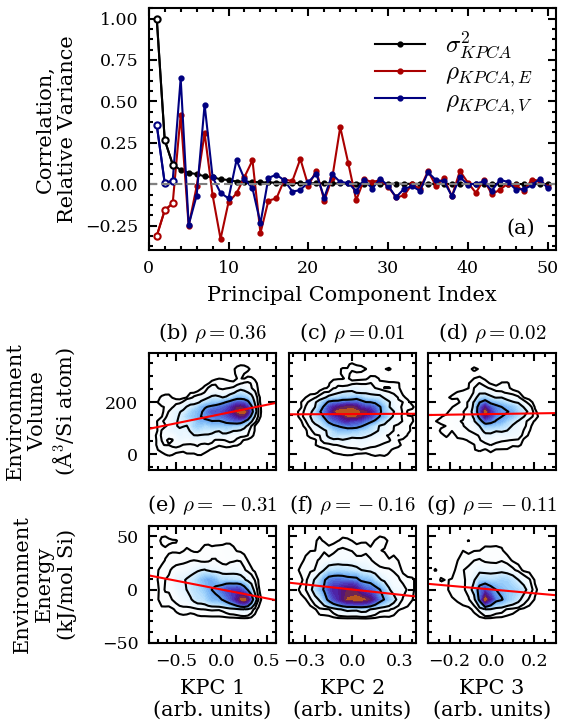

In [181]:
nPCA = 50
n_grid = 40
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
x = np.arange(1, nPCA+1)
fig3 = plt.figure(figsize=(3.5, 5.5))

gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)

axs3 = fig3.add_subplot(gs_data[0:2, :])

axs3.plot(x, var3[0:nPCA]/var3[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs3.plot(x, ccE3[0:nPCA], marker='o', label=r'$\rho_{KPCA, E}$')
axs3.plot(x, ccV3[0:nPCA], marker='o', label=r'$\rho_{KPCA, V}$')
axs3.set_prop_cycle(None)
axs3.plot(x[0:3], var3[0:3]/var3[0], marker='o', markerfacecolor='w', markersize=3)
axs3.plot(x[0:3], ccE3[0:3], marker='o', markerfacecolor='w', markersize=3)
axs3.plot(x[0:3], ccV3[0:3], marker='o', markerfacecolor='w', markersize=3)
axs3.set_xlabel('Principal Component Index')
axs3.set_ylabel('Correlation,\nRelative Variance')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xlim((0, 51))

axs3.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs3.transAxes)
axs3.legend(fontsize='large', labelspacing=0)

### 1k Energy, Volume KDE plots ###
### SOAP 3.5 ###

### Volume Correlation ###
yV = np.linspace(volumes_1k_3A.min()-volumes_1k_3A.std(), 
                 volumes_1k_3A.max()+volumes_1k_3A.std(), n_grid)
yE = np.linspace(energies_1k_3A.min()-energies_1k_3A.std(), 
                 energies_1k_3A.max()+energies_1k_3A.std(), n_grid)

for i in range(0, 3):
    axsVol = fig3.add_subplot(gs_data[4, i])
    axsVol_label = fig3.add_subplot(gs_data[3, i])
    
    for j in ['top', 'bottom', 'left', 'right']:
        axsVol_label.spines[j].set_visible(False)
    axsVol_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    x = np.linspace(kpca_1k_3A[:, i].min()-kpca_1k_3A[:, i].std(), 
                kpca_1k_3A[:, i].max()+kpca_1k_3A[:, i].std(), n_grid)

    xx, yy = np.meshgrid(x, yV)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    kde = gaussian_kde(np.vstack([kpca_1k_3A[:, i], volumes_1k_3A]))

    zz = np.reshape(kde(pos).T, xx.shape)

    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)

    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    axsVol.contourf(xx, yy, zz, levels=levelsf)
    axsVol.contour(xx, yy, zz, levels=levels, colors='k')
    
    m, b, r, p, s = linregress(kpca_1k_3A[:, i], volumes_1k_3A)
    axsVol.plot(x, m*x+b, linestyle='-', color='r')
    
    if i == 0:
        axsVol.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsVol.set_yticklabels([])
    axsVol.set_xticklabels([])
        
    if i == 0:
        axsVol.set_xlim([-0.8, 0.6])
        axsVol.set_xticks([-0.5, 0.0, 0.5])
    elif i == 1:
        axsVol.set_xlim([-0.4, 0.4])
        axsVol.set_xticks([-0.3, 0.0, 0.3])
    else:
        axsVol.set_xlim([-0.3, 0.3])
        axsVol.set_xticks([-0.2, 0.0, 0.2])
        
    #axsVol.set_ylim([-20, 130])
    axsVol.set_ylim([-60, 390])

    axsVol_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccV3[i]),
                horizontalalignment='center', verticalalignment='bottom', transform=axsVol_label.transAxes)
    
### Energy Correlation ###
for i in range(0, 3):
    axsE = fig3.add_subplot(gs_data[6, i])
    axsE_label = fig3.add_subplot(gs_data[5, i])
    
    for j in ['top', 'bottom', 'left', 'right']:
        axsE_label.spines[j].set_visible(False)
    axsE_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    x = np.linspace(kpca_1k_3A[:, i].min()-kpca_1k_3A[:, i].std(), 
                kpca_1k_3A[:, i].max()+kpca_1k_3A[:, i].std(), n_grid)

    xx, yy = np.meshgrid(x, yE)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    kde = gaussian_kde(np.vstack([kpca_1k_3A[:, i], energies_1k_3A]))

    zz = np.reshape(kde(pos).T, xx.shape)

    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)

    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    axsE.contourf(xx, yy, zz, levels=levelsf)
    axsE.contour(xx, yy, zz, levels=levels, colors='k')
    
    m, b, r, p, s = linregress(kpca_1k_3A[:, i], energies_1k_3A)
    axsE.plot(x, m*x+b, linestyle='-', color='r')
    
    if i == 0:
        axsE.set_ylabel('Environment\nEnergy\n(kJ/mol Si)')
    else:
        axsE.set_yticklabels([])
    axsE.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    if i == 0:
        axsE.set_xlim([-0.8, 0.6])
        axsE.set_xticks([-0.5, 0.0, 0.5])
    elif i == 1:
        axsE.set_xlim([-0.4, 0.4])
        axsE.set_xticks([-0.3, 0.0, 0.3])
    else:
        axsE.set_xlim([-0.3, 0.3])
        axsE.set_xticks([-0.2, 0.0, 0.2])
        
    axsE.set_ylim([-50, 60])
    
    axsE_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccE3[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsE_label.transAxes)
    
fig3.align_ylabels()
fig3.savefig('../Results/DEEM_1k/kpca_energy-volume-correlation_3.5_1k.pdf', bbox_inches='tight')

plt.show()

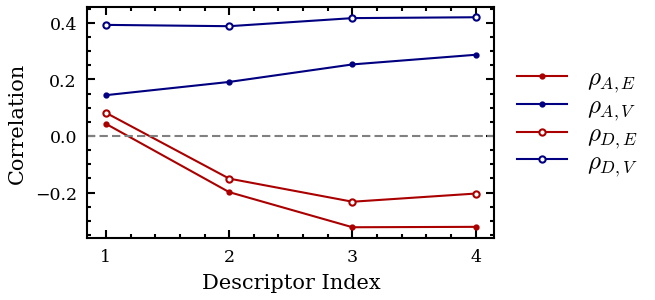

In [182]:
x = np.arange(1, angles_1k.shape[1]+1)
fig3 = plt.figure(figsize=(3.5, 2.0))
axs3 = fig3.add_subplot(1, 1, 1)

axs3.plot(x, ccAE3, marker='o', c=ccycle[1], label=r'$\rho_{A, E}$')
axs3.plot(x, ccAV3, marker='o', c=ccycle[2], label=r'$\rho_{A, V}$')
axs3.plot(x, ccDE3, marker='o', c=ccycle[1], markerfacecolor='w', markersize=3, label=r'$\rho_{D, E}$')
axs3.plot(x, ccDV3, marker='o', c=ccycle[2], markerfacecolor='w', markersize=3, label=r'$\rho_{D, V}$')

axs3.set_xlabel('Descriptor Index')
axs3.set_ylabel('Correlation')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xticks([1, 2, 3, 4])

axs3.legend(fontsize='large', labelspacing=0, loc='center left', bbox_to_anchor=(1.0, 0.5))

#fig3.savefig('../Results/DEEM_1k/correlation_classical_3.5_1k.pdf', bbox_inches='tight')
plt.show()

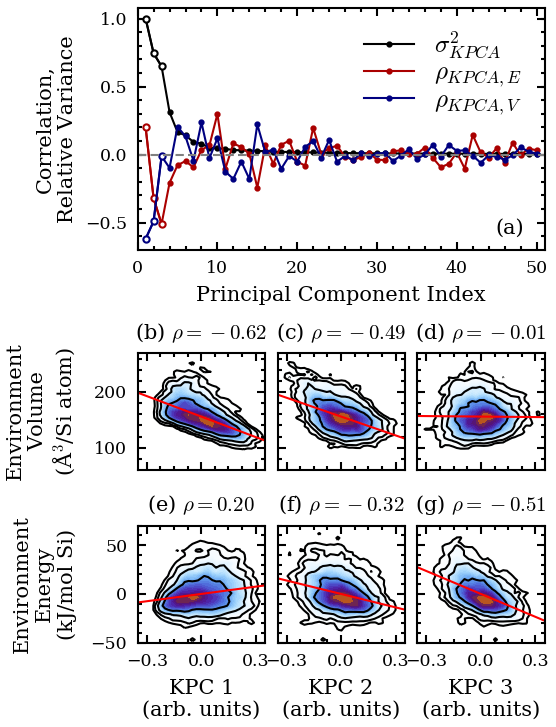

In [183]:
nPCA = 50
n_grid = 40
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
x = np.arange(1, nPCA+1)
fig6 = plt.figure(figsize=(3.5, 5.5))

gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)

axs6 = fig6.add_subplot(gs_data[0:2, :])

axs6.plot(x, var6[0:nPCA]/var6[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs6.plot(x, ccE6[0:nPCA], marker='o', label=r'$\rho_{KPCA, E}$')
axs6.plot(x, ccV6[0:nPCA], marker='o', label=r'$\rho_{KPCA, V}$')
axs6.set_prop_cycle(None)
axs6.plot(x[0:3], var6[0:3]/var6[0], marker='o', markerfacecolor='w', markersize=3)
axs6.plot(x[0:3], ccE6[0:3], marker='o', markerfacecolor='w', markersize=3)
axs6.plot(x[0:3], ccV6[0:3], marker='o', markerfacecolor='w', markersize=3)
axs6.set_xlabel('Principal Component Index')
axs6.set_ylabel('Correlation,\nRelative Variance')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xlim((0, 51))

axs6.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs6.transAxes)
axs6.legend(fontsize='large', labelspacing=0)

### 1k Energy, Volume KDE plots ###
### SOAP 6.0 ###

### Volume Correlation ###
yV = np.linspace(volumes_1k_6A.min()-volumes_1k_6A.std(),
                 volumes_1k_6A.max()+volumes_1k_6A.std(), n_grid)
yE = np.linspace(energies_1k_6A.min()-energies_1k_6A.std(),
                 energies_1k_6A.max()+energies_1k_6A.std(), n_grid)

for i in range(0, 3):
    axsVol = fig6.add_subplot(gs_data[4, i])
    axsVol_label = fig6.add_subplot(gs_data[3, i])
    
    for j in ['top', 'bottom', 'left', 'right']:
        axsVol_label.spines[j].set_visible(False)
    axsVol_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    x = np.linspace(kpca_1k_6A[:, i].min()-kpca_1k_6A[:, i].std(), 
                    kpca_1k_6A[:, i].max()+kpca_1k_6A[:, i].std(), n_grid)
    
    xx, yy = np.meshgrid(x, yV)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    kde = gaussian_kde(np.vstack([kpca_1k_6A[:, i], volumes_1k_6A]))

    zz = np.reshape(kde(pos).T, xx.shape)

    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)

    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    axsVol.contourf(xx, yy, zz, levels=levelsf)
    axsVol.contour(xx, yy, zz, levels=levels, colors='k')
    
    m, b, r, p, s = linregress(kpca_1k_6A[:, i], volumes_1k_6A)
    axsVol.plot(x, m*x+b, linestyle='-', color='r')
    
    if i == 0:
        axsVol.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsVol.set_yticklabels([])
    
    axsVol.set_xticklabels([])
    
    axsVol.set_xlim([-0.35, 0.35])
    axsVol.set_xticks([-0.3, 0.0, 0.3])
    
    #axsVol.set_ylim([20, 90])
    axsVol.set_ylim([60, 270])
    
    axsVol_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccV6[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsVol_label.transAxes)
    
### Energy Correlation ###
for i in range(0, 3):
    axsE = fig6.add_subplot(gs_data[6, i])
    axsE_label = fig6.add_subplot(gs_data[5, i])
    
    for j in ['top', 'bottom', 'left', 'right']:
        axsE_label.spines[j].set_visible(False)
    axsE_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    x = np.linspace(kpca_1k_6A[:, i].min()-kpca_1k_6A[:, i].std(), 
                    kpca_1k_6A[:, i].max()+kpca_1k_6A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yE)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    kde = gaussian_kde(np.vstack([kpca_1k_6A[:, i], energies_1k_6A]))

    zz = np.reshape(kde(pos).T, xx.shape)

    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)

    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    axsE.contourf(xx, yy, zz, levels=levelsf)
    axsE.contour(xx, yy, zz, levels=levels, colors='k')
    
    m, b, r, p, s = linregress(kpca_1k_6A[:, i], energies_1k_6A)
    axsE.plot(x, m*x+b, linestyle='-', color='r')
        
    if i == 0:
        axsE.set_ylabel('Environment\nEnergy\n(kJ/mol Si)')
    else:
        axsE.set_yticklabels([])
    axsE.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    axsE.set_xlim([-0.35, 0.35])
    axsE.set_xticks([-0.3, 0.0, 0.3])
    
    axsE.set_ylim([-50, 70])
    
    axsE_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccE6[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsE_label.transAxes)

fig6.align_ylabels()
fig6.savefig('../Results/DEEM_1k/kpca_energy-volume-correlation_6.0_1k.pdf', bbox_inches='tight')
plt.show()

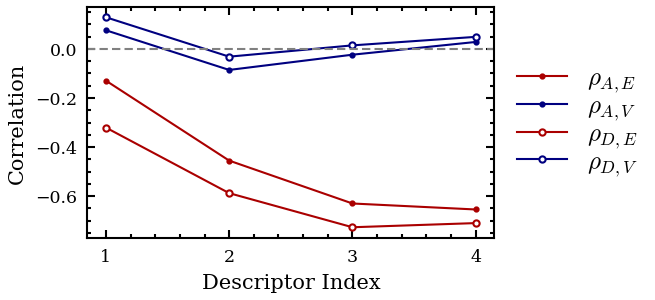

In [184]:
x = np.arange(1, angles_1k.shape[1]+1)
fig6 = plt.figure(figsize=(3.5, 2.0))
axs6 = fig6.add_subplot(1, 1, 1)

axs6.plot(x, ccAE6, marker='o', c=ccycle[1], label=r'$\rho_{A, E}$')
axs6.plot(x, ccAV6, marker='o', c=ccycle[2], label=r'$\rho_{A, V}$')
axs6.plot(x, ccDE6, marker='o', c=ccycle[1], markerfacecolor='w', markersize=3, label=r'$\rho_{D, E}$')
axs6.plot(x, ccDV6, marker='o', c=ccycle[2], markerfacecolor='w', markersize=3, label=r'$\rho_{D, V}$')

axs6.set_xlabel('Descriptor Index')
axs6.set_ylabel('Correlation')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xticks([1, 2, 3, 4])

axs6.legend(fontsize='large', labelspacing=0, loc='center left', bbox_to_anchor=(1.0, 0.5))

#fig6.savefig('../Results/DEEM_1k/correlation_classical_6.0_1k.pdf', bbox_inches='tight')
plt.show()

## 10k Data

In [185]:
# Alternatively, compute correlation coefficient iteratively (3.5 A)
# Calculate mean, variance
#
# Online variance algorithm adapted from:
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
# http://jonisalonen.com/2013/deriving-welfords-method-for-computing-variance/
# https://www.johndcook.com/blog/standard_deviation/
n = 0
nBatch = 10
energies_10k_3A = []
volumes_10k_3A = []
kpca_10k_3A = []
for i in range(0, nBatch):
    ikpca_10k_3A = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/3.5/Gaussian/envProperties-%d.dat' % i)*3 # Normalize per Si atom
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/3.5/Gaussian/envProperties-%d.dat' % i)
    energies_10k_3A.append(ienergy)
    volumes_10k_3A.append(ivol)
    kpca_10k_3A.append(ikpca_10k_3A[:, 0:3])

    if i == 0:
        var3 = np.zeros(ikpca_10k_3A.shape[1])
        mean3 = np.zeros(ikpca_10k_3A.shape[1])
        varE3 = 0
        meanE3 = 0
        varV3 = 0
        meanV3 = 0
    for j in range(0, ikpca_10k_3A.shape[0]):
        n += 1
        mean3_old = mean3.copy()
        mean3 += (ikpca_10k_3A[j, :]-mean3)/n
        var3 += (ikpca_10k_3A[j, :]-mean3)*(ikpca_10k_3A[j, :]-mean3_old)
            
        meanE3_old = meanE3
        meanE3 += (ienergy[j]-meanE3)/n
        varE3 += (ienergy[j]-meanE3)*(ienergy[j]-meanE3_old)
            
        meanV3_old = meanV3
        meanV3 += (ivol[j]-meanV3)/n
        varV3 += (ivol[j]-meanV3)*(ivol[j]-meanV3_old)

energies_10k_3A = np.concatenate(energies_10k_3A)
volumes_10k_3A = np.concatenate(volumes_10k_3A)
kpca_10k_3A = np.concatenate(kpca_10k_3A)
        
var3 /= n
varE3 /= n
varV3 /= n

# Calculate correlation coefficient
ccV3 = np.zeros(len(var3))
ccE3 = np.zeros(len(var3))

for i in range(0, nBatch):
    ikpca_10k_3A = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/3.5/Gaussian/envProperties-%d.dat' % i)*3 # Normalize per Si atom
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/3.5/Gaussian/envProperties-%d.dat' % i)

    for j in range(0, ikpca_10k_3A.shape[1]):    
        ccE3[j] += np.dot(ienergy-meanE3, ikpca_10k_3A[:, j]-mean3[j])/(np.sqrt(varE3*var3[j])*n)
        ccV3[j] += np.dot(ivol-meanV3, ikpca_10k_3A[:, j]-mean3[j])/(np.sqrt(varV3*var3[j])*n)

In [186]:
# Alternatively, compute correlation coefficient iteratively (6.0 A)
# Calculate mean, variance
n = 0
nBatch = 10
energies_10k_6A = []
volumes_10k_6A = []
kpca_10k_6A = []
for i in range(0, nBatch):
    ikpca_10k_6A = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/6.0/Gaussian/envProperties-%d.dat' % i)*3 # Normalize per Si atom
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/6.0/Gaussian/envProperties-%d.dat' % i)
    energies_10k_6A.append(ienergy)
    volumes_10k_6A.append(ivol)
    kpca_10k_6A.append(ikpca_10k_6A[:, 0:3])
    if i == 0:
        var6 = np.zeros(ikpca_10k_6A.shape[1])
        mean6 = np.zeros(ikpca_10k_6A.shape[1])
        varE6 = 0
        meanE6 = 0
        varV6 = 0
        meanV6 = 0
    for j in range(0, ikpca_10k_6A.shape[0]):
        n += 1
        mean6_old = mean6.copy()
        mean6 += (ikpca_10k_6A[j, :]-mean6)/n
        var6 += (ikpca_10k_6A[j, :]-mean6)*(ikpca_10k_6A[j, :]-mean6_old)
            
        meanE6_old = meanE6
        meanE6 += (ienergy[j]-meanE6)/n
        varE6 += (ienergy[j]-meanE6)*(ienergy[j]-meanE6_old)
            
        meanV6_old = meanV6
        meanV6 += (ivol[j]-meanV6)/n
        varV6 += (ivol[j]-meanV6)*(ivol[j]-meanV6_old)
        
energies_10k_6A = np.concatenate(energies_10k_6A)
volumes_10k_6A = np.concatenate(volumes_10k_6A)
kpca_10k_6A = np.concatenate(kpca_10k_6A)
        
var6 /= n
varE6 /= n
varV6 /= n

# Calculate correlation coefficient
ccV6 = np.zeros(len(var6))
ccE6 = np.zeros(len(var6))

for i in range(0, nBatch):
    ikpca_10k_6A = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    ivol = np.loadtxt('../Processed_Data/DEEM_10k/Volume/6.0/Gaussian/envProperties-%d.dat' % i)*3 # Normalize per Si atom
    ienergy = np.loadtxt('../Processed_Data/DEEM_10k/Energy/6.0/Gaussian/envProperties-%d.dat' % i)

    for j in range(0, ikpca_10k_6A.shape[1]):    
        ccE6[j] += np.dot(ienergy-meanE6, ikpca_10k_6A[:, j]-mean6[j])/(np.sqrt(varE6*var6[j])*n)
        ccV6[j] += np.dot(ivol-meanV6, ikpca_10k_6A[:, j]-mean6[j])/(np.sqrt(varV6*var6[j])*n)

In [187]:
angles_10k = np.loadtxt('../Processed_Data/DEEM_10k/Angles/angles.dat')
distances_10k = np.loadtxt('../Processed_Data/DEEM_10k/Distances/distances.dat')

varA = angles_10k.var(axis=0)
varD = distances_10k.var(axis=0)

In [188]:
ccAV3 = np.zeros(len(varA))
ccAV6 = np.zeros(len(varA))
ccAE3 = np.zeros(len(varA))
ccAE6 = np.zeros(len(varA))
ccDV3 = np.zeros(len(varD))
ccDV6 = np.zeros(len(varD))
ccDE3 = np.zeros(len(varD))
ccDE6 = np.zeros(len(varD))
    
for i in range(0, angles_10k.shape[1]):
    ccAE3[i] = cc(angles_10k[:, i], energies_10k_3A)
    ccAE6[i] = cc(angles_10k[:, i], energies_10k_6A)
    ccAV3[i] = cc(angles_10k[:, i], volumes_10k_3A)
    ccAV6[i] = cc(angles_10k[:, i], volumes_10k_6A)
    
for i in range(0, distances_10k.shape[1]):    
    ccDE3[i] = cc(distances_10k[:, i], energies_10k_3A)
    ccDE6[i] = cc(distances_10k[:, i], energies_10k_6A)
    ccDV3[i] = cc(distances_10k[:, i], volumes_10k_3A)
    ccDV6[i] = cc(distances_10k[:, i], volumes_10k_6A)

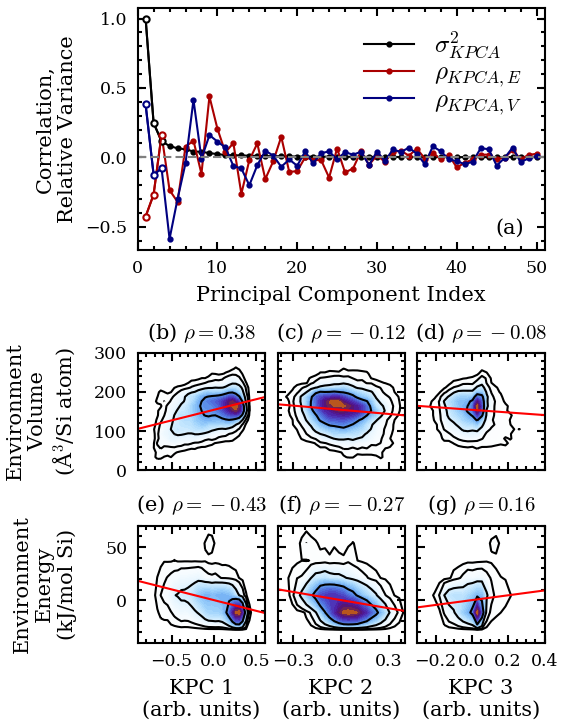

In [189]:
nPCA = 50
n_grid = 40
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
x = np.arange(1, nPCA+1)
fig3 = plt.figure(figsize=(3.5, 5.5))

gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)

axs3 = fig3.add_subplot(gs_data[0:2, :])

axs3.plot(x, var3[0:nPCA]/var3[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs3.plot(x, ccE3[0:nPCA], marker='o', label=r'$\rho_{KPCA, E}$')
axs3.plot(x, ccV3[0:nPCA], marker='o', label=r'$\rho_{KPCA, V}$')
axs3.set_prop_cycle(None)
axs3.plot(x[0:3], var3[0:3]/var3[0], marker='o', markerfacecolor='w', markersize=3)
axs3.plot(x[0:3], ccE3[0:3], marker='o', markerfacecolor='w', markersize=3)
axs3.plot(x[0:3], ccV3[0:3], marker='o', markerfacecolor='w', markersize=3)
axs3.set_xlabel('Principal Component Index')
axs3.set_ylabel('Correlation,\nRelative Variance')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xlim((0, 51))

axs3.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs3.transAxes)
axs3.legend(fontsize='large', labelspacing=0)

### 10k Energy, Volume KDE plots ###
### SOAP 3.5 ###

### Volume Correlation ###
yV = np.linspace(volumes_10k_3A.min()-volumes_10k_3A.std(),
                 volumes_10k_3A.max()+volumes_10k_3A.std(), n_grid)
yE = np.linspace(energies_10k_3A.min()-energies_10k_3A.std(),
                 energies_10k_3A.max()+energies_10k_3A.std(), n_grid)

for i in range(0, 3):
    axsVol = fig3.add_subplot(gs_data[4, i])
    axsVol_label = fig3.add_subplot(gs_data[3, i])
    
    for j in ['top', 'bottom', 'left', 'right']:
        axsVol_label.spines[j].set_visible(False)
    axsVol_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    x = np.linspace(kpca_10k_3A[:, i].min()-kpca_10k_3A[:, i].std(),
                    kpca_10k_3A[:, i].max()+kpca_10k_3A[:, i].std(), n_grid)
    
    xx, yy = np.meshgrid(x, yV)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    kde = gaussian_kde(np.vstack([kpca_10k_3A[:, i], volumes_10k_3A]))

    zz = np.reshape(kde(pos).T, xx.shape)

    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)

    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    axsVol.contourf(xx, yy, zz, levels=levelsf)
    axsVol.contour(xx, yy, zz, levels=levels, colors='k')
    
    m, b, r, p, s = linregress(kpca_10k_3A[:, i], volumes_10k_3A)
    axsVol.plot(x, m*x+b, linestyle='-', color='r')
    
    if i == 0:
        axsVol.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsVol.set_yticklabels([])
    axsVol.set_xticklabels([])
        
    if i == 0:
        axsVol.set_xlim([-0.9, 0.6])
        axsVol.set_xticks([-0.5, 0.0, 0.5])
    elif i == 1:
        axsVol.set_xlim([-0.4, 0.4])
        axsVol.set_xticks([-0.3, 0.0, 0.3])
    else:
        axsVol.set_xlim([-0.3, 0.4])
        axsVol.set_xticks([-0.2, 0.0, 0.2])
        
    #axsVol.set_ylim([0, 100])
    axsVol.set_ylim([0, 300])
    
    axsVol_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccV3[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsVol_label.transAxes)
    
### Energy Correlation ###
for i in range(0, 3):
    axsE = fig3.add_subplot(gs_data[6, i])
    axsE_label = fig3.add_subplot(gs_data[5, i])
    
    for j in ['top', 'bottom', 'left', 'right']:
        axsE_label.spines[j].set_visible(False)
    axsE_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    x = np.linspace(kpca_10k_3A[:, i].min()-kpca_10k_3A[:, i].std(),
                    kpca_10k_3A[:, i].max()+kpca_10k_3A[:, i].std(), n_grid)
    
    xx, yy = np.meshgrid(x, yE)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    kde = gaussian_kde(np.vstack([kpca_10k_3A[:, i], energies_10k_3A]))

    zz = np.reshape(kde(pos).T, xx.shape)

    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)

    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    axsE.contourf(xx, yy, zz, levels=levelsf)
    axsE.contour(xx, yy, zz, levels=levels, colors='k')
    
    m, b, r, p, s = linregress(kpca_10k_3A[:, i], energies_10k_3A)
    axsE.plot(x, m*x+b, linestyle='-', color='r')
    
    if i == 0:
        axsE.set_ylabel('Environment\nEnergy\n(kJ/mol Si)')
    else:
        axsE.set_yticklabels([])
    axsE.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    if i == 0:
        axsE.set_xlim([-0.9, 0.6])
        axsE.set_xticks([-0.5, 0.0, 0.5])
    elif i == 1:
        axsE.set_xlim([-0.4, 0.4])
        axsE.set_xticks([-0.3, 0.0, 0.3])
    else:
        axsE.set_xlim([-0.3, 0.4])
        axsE.set_xticks([-0.2, 0.0, 0.2, 0.4])
        
    axsE.set_ylim([-40, 70])
    
    axsE_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccE3[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsE_label.transAxes)

fig3.align_ylabels()
fig3.savefig('../Results/DEEM_10k/kpca_energy-volume-correlation_3.5_10k.pdf', bbox_inches='tight')
plt.show()

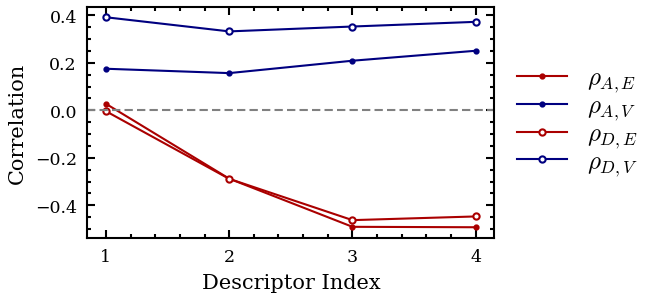

In [190]:
x = np.arange(1, angles_10k.shape[1]+1)
fig3 = plt.figure(figsize=(3.5, 2.0))
axs3 = fig3.add_subplot(1, 1, 1)

axs3.plot(x, ccAE3, marker='o', c=ccycle[1], label=r'$\rho_{A, E}$')
axs3.plot(x, ccAV3, marker='o', c=ccycle[2], label=r'$\rho_{A, V}$')
axs3.plot(x, ccDE3, marker='o', c=ccycle[1], markerfacecolor='w', markersize=3, label=r'$\rho_{D, E}$')
axs3.plot(x, ccDV3, marker='o', c=ccycle[2], markerfacecolor='w', markersize=3, label=r'$\rho_{D, V}$')

axs3.set_xlabel('Descriptor Index')
axs3.set_ylabel('Correlation')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xticks([1, 2, 3, 4])

axs3.legend(fontsize='large', labelspacing=0, loc='center left', bbox_to_anchor=(1.0, 0.5))

#fig3.savefig('../Results/DEEM_10k/correlation_classical_3.5_10k.pdf', bbox_inches='tight')
plt.show()

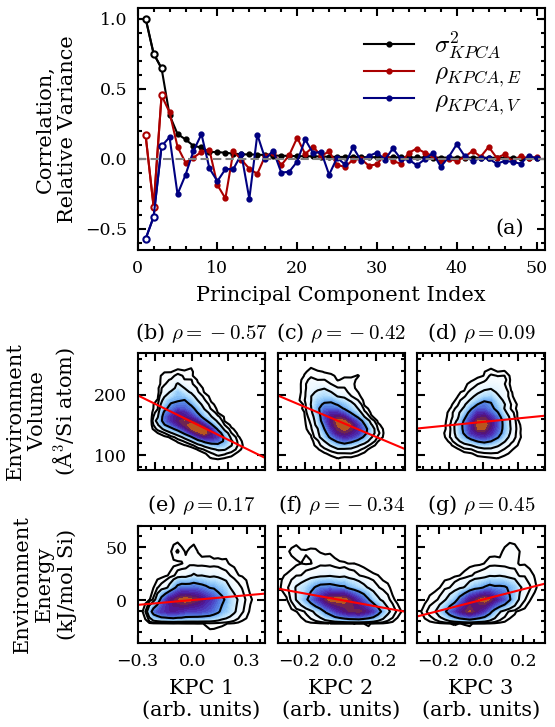

In [191]:
nPCA = 50
n_grid = 40
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
x = np.arange(1, nPCA+1)
fig6 = plt.figure(figsize=(3.5, 5.5))

gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)

axs6 = fig6.add_subplot(gs_data[0:2, :])

axs6.plot(x, var6[0:nPCA]/var6[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs6.plot(x, ccE6[0:nPCA], marker='o', label=r'$\rho_{KPCA, E}$')
axs6.plot(x, ccV6[0:nPCA], marker='o', label=r'$\rho_{KPCA, V}$')
axs6.set_prop_cycle(None)
axs6.plot(x[0:3], var6[0:3]/var6[0], marker='o', markerfacecolor='w', markersize=3)
axs6.plot(x[0:3], ccE6[0:3], marker='o', markerfacecolor='w', markersize=3)
axs6.plot(x[0:3], ccV6[0:3], marker='o', markerfacecolor='w', markersize=3)
axs6.set_xlabel('Principal Component Index')
axs6.set_ylabel('Correlation,\nRelative Variance')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xlim((0, 51))

axs6.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs6.transAxes)
axs6.legend(fontsize='large', labelspacing=0)

### 10k Energy, Volume KDE plots ###
### SOAP 6.0 ###

### Volume Correlation ###
yV = np.linspace(volumes_10k_6A.min()-volumes_10k_6A.std(),
                 volumes_10k_6A.max()+volumes_10k_6A.std(), n_grid)
yE = np.linspace(energies_10k_6A.min()-energies_10k_6A.std(), 
                 energies_10k_6A.max()+energies_10k_6A.std(), n_grid)

for i in range(0, 3):
    axsVol = fig6.add_subplot(gs_data[4, i])
    axsVol_label = fig6.add_subplot(gs_data[3, i])
    
    for j in ['top', 'bottom', 'left', 'right']:
        axsVol_label.spines[j].set_visible(False)
    axsVol_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    x = np.linspace(kpca_10k_6A[:, i].min()-kpca_10k_6A[:, i].std(),
                    kpca_10k_6A[:, i].max()+kpca_10k_6A[:, i].std(), 20)
    
    xx, yy = np.meshgrid(x, yV)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    kde = gaussian_kde(np.vstack([kpca_10k_6A[:, i], volumes_10k_6A]))

    zz = np.reshape(kde(pos).T, xx.shape)

    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)

    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    axsVol.contourf(xx, yy, zz, levels=levelsf)
    axsVol.contour(xx, yy, zz, levels=levels, colors='k')
    
    m, b, r, p, s = linregress(kpca_10k_6A[:, i], volumes_10k_6A)
    axsVol.plot(x, m*x+b, linestyle='-', color='r')
    
    if i == 0:
        axsVol.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$/Si atom)')
    else:
        axsVol.set_yticklabels([])
    axsVol.set_xticklabels([])
    
    #axsVol.set_ylim([25, 90])
    axsVol.set_ylim([75, 270])
    
    axsVol_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccV6[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsVol_label.transAxes)
    
### Energy Correlation ###
for i in range(0, 3):
    axsE = fig6.add_subplot(gs_data[6, i])
    axsE_label = fig6.add_subplot(gs_data[5, i])
    
    for j in ['top', 'bottom', 'left', 'right']:
        axsE_label.spines[j].set_visible(False)
    axsE_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)

    x = np.linspace(kpca_10k_6A[:, i].min()-kpca_10k_6A[:, i].std(),
                    kpca_10k_6A[:, i].max()+kpca_10k_6A[:, i].std(), n_grid)

    xx, yy = np.meshgrid(x, yE)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    kde = gaussian_kde(np.vstack([kpca_10k_6A[:, i], energies_10k_6A]))

    zz = np.reshape(kde(pos).T, xx.shape)

    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)

    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)

    axsE.contourf(xx, yy, zz, levels=levelsf)
    axsE.contour(xx, yy, zz, levels=levels, colors='k')
    
    m, b, r, p, s = linregress(kpca_10k_6A[:, i], energies_10k_6A)
    axsE.plot(x, m*x+b, linestyle='-', color='r')
    
    if i == 0:
        axsE.set_ylabel('Environment\nEnergy\n(kJ/mol Si)')
    else:
        axsE.set_yticklabels([])
    axsE.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    if i == 0:
        axsE.set_xlim([-0.3, 0.4])
        axsE.set_xticks([-0.3, 0.0, 0.3])
    elif i == 1:
        axsE.set_xlim([-0.3, 0.3])
        axsE.set_xticks([-0.2, 0.0, 0.2])
    else:
        axsE.set_xlim([-0.3, 0.3])
        axsE.set_xticks([-0.2, 0.0, 0.2])    
        
    axsE.set_ylim([-40, 70])
    
    axsE_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccE6[i]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsE_label.transAxes)

fig6.align_ylabels()    
fig6.savefig('../Results/DEEM_10k/kpca_energy-volume-correlation_6.0_10k.pdf', bbox_inches='tight')
plt.show()

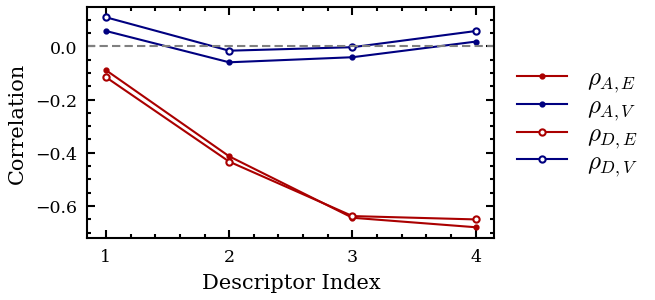

In [192]:
x = np.arange(1, angles_10k.shape[1]+1)
fig6 = plt.figure(figsize=(3.5, 2.0))
axs6 = fig6.add_subplot(1, 1, 1)

axs6.plot(x, ccAE6, marker='o', c=ccycle[1], label=r'$\rho_{A, E}$')
axs6.plot(x, ccAV6, marker='o', c=ccycle[2], label=r'$\rho_{A, V}$')
axs6.plot(x, ccDE6, marker='o', c=ccycle[1], markerfacecolor='w', markersize=3, label=r'$\rho_{D, E}$')
axs6.plot(x, ccDV6, marker='o', c=ccycle[2], markerfacecolor='w', markersize=3, label=r'$\rho_{D, V}$')

axs6.set_xlabel('Descriptor Index')
axs6.set_ylabel('Correlation')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xticks([1, 2, 3, 4])

axs6.legend(fontsize='large', labelspacing=0, loc='center left', bbox_to_anchor=(1.0, 0.5))

#fig6.savefig('../Results/DEEM_10k/correlation_classical_6.0_10k.pdf', bbox_inches='tight')
plt.show()

# Volume/Energy Correlations in Environments and Frameworks

## 1k data

In [193]:
# Load framework volumes and energies
framework_volumes_1k, framework_energies_1k, structure_idxs_1k = \
    load_framework_data('../Processed_Data/DEEM_1k/atoms.dat')

In [194]:
# 3.5 A SOAP
n_grid = 40
#vrange = np.linspace(-20, 120, n_grid)
vrange = np.linspace(-60, 360, n_grid)
erange = np.linspace(-50, 100, n_grid)
vv, ee = np.meshgrid(vrange, erange)
pos = np.vstack([vv.ravel(), ee.ravel()])
kde_frameworks_1k = gaussian_kde(np.vstack([framework_volumes_1k, framework_energies_1k]))
z_frameworks_1k = np.reshape(kde_frameworks_1k(pos).T, vv.shape)
kde_environments_1k_3A = gaussian_kde(np.vstack([volumes_1k_3A, energies_1k_3A]))
z_environments_1k_3A = np.reshape(kde_environments_1k_3A(pos).T, vv.shape)

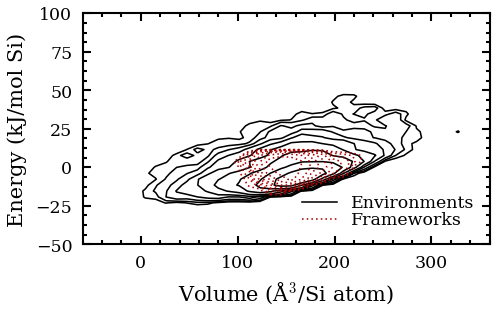

In [195]:
# 3.5 A SOAP
figFramework = plt.figure(figsize=(3.5, 2.0))
axsFramework = figFramework.add_subplot(1, 1, 1)

n_lvls = 10
lvlsEnv = np.logspace(np.log10(z_environments_1k_3A.max()*1.0E-2), 
                      np.log10(z_environments_1k_3A.max()), n_lvls)
lvlsFrame = np.logspace(np.log10(z_frameworks_1k.max()*1.0E-2), 
                        np.log10(z_frameworks_1k.max()), n_lvls)

contour_environments = axsFramework.contour(vv, ee, z_environments_1k_3A,
                                             linestyles='solid', linewidths=0.75, colors=ccycle[0], 
                                             levels=lvlsEnv, zorder=1)
contour_framework = axsFramework.contour(vv, ee, z_frameworks_1k, 
                                          linestyles='dotted', linewidths=0.75, colors=ccycle[1], 
                                          levels=lvlsFrame, zorder=2)


# WARNING: OUTLIERS!
axsFramework.set_ylim([-50, 100])
#axsFramework.set_xlim([-20, 120])
axsFramework.set_xlim([-60, 360])

axsFramework.set_xlabel('Volume ' + ur'(\u00c5$^3$/Si atom)')
axsFramework.set_ylabel('Energy (kJ/mol Si)')

line_env = mpllines.Line2D([0], [0], color=ccycle[0], linewidth=0.75, linestyle='-', label='Environments')
line_frame = mpllines.Line2D([0], [0], color=ccycle[1], linewidth=0.75, linestyle=':', label='Frameworks')

axsFramework.legend(handles=[line_env, line_frame], labelspacing=0, 
                    loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()

In [196]:
# 6.0 A SOAP
n_grid = 40
#vrange = np.linspace(20, 100, n_grid)
vrange = np.linspace(60, 300, n_grid)
erange = np.linspace(-75, 100, n_grid)
vv, ee = np.meshgrid(vrange, erange)
pos = np.vstack([vv.ravel(), ee.ravel()])
kde_frameworks_1k = gaussian_kde(np.vstack([framework_volumes_1k, framework_energies_1k]))
z_frameworks_1k = np.reshape(kde_frameworks_1k(pos).T, vv.shape)
kde_environments_1k_6A = gaussian_kde(np.vstack([volumes_1k_6A, energies_1k_6A]))
z_environments_1k_6A = np.reshape(kde_environments_1k_6A(pos).T, vv.shape)

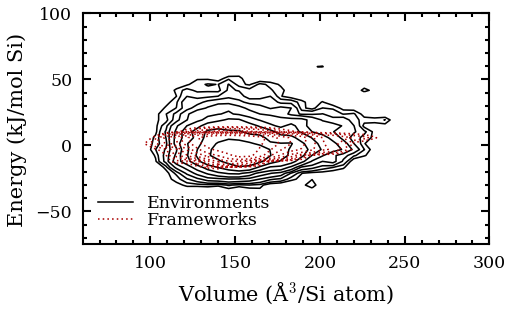

In [197]:
# 6.0 A SOAP
figFramework = plt.figure(figsize=(3.5, 2.0))
axsFramework = figFramework.add_subplot(1, 1, 1)

n_lvls = 10
lvlsEnv = np.logspace(np.log10(z_environments_1k_6A.max()*1.0E-2), 
                      np.log10(z_environments_1k_6A.max()), n_lvls)
lvlsFrame = np.logspace(np.log10(z_frameworks_1k.max()*1.0E-2), 
                        np.log10(z_frameworks_1k.max()), n_lvls)

contour_environments = axsFramework.contour(vv, ee, z_environments_1k_6A,
                                             linestyles='solid', linewidths=0.75, colors=ccycle[0], 
                                             levels=lvlsEnv, zorder=1)
contour_framework = axsFramework.contour(vv, ee, z_frameworks_1k, 
                                          linestyles='dotted', linewidths=0.75, colors=ccycle[1], 
                                          levels=lvlsFrame, zorder=2)

axsFramework.set_ylim([-75, 100])
#axsFramework.set_xlim([20, 100])
axsFramework.set_xlim([60, 300])

axsFramework.set_xlabel('Volume ' + ur'(\u00c5$^3$/Si atom)')
axsFramework.set_ylabel('Energy (kJ/mol Si)')

line_env = mpllines.Line2D([0], [0], color=ccycle[0], linewidth=0.75, linestyle='-', label='Environments')
line_frame = mpllines.Line2D([0], [0], color=ccycle[1], linewidth=0.75, linestyle=':', label='Frameworks')

axsFramework.legend(handles=[line_env, line_frame], labelspacing=0, 
                    loc='lower left', bbox_to_anchor=(0.0, 0.0))

plt.show()

## 10k data

In [198]:
# Load framework volumes and energies
framework_volumes_10k, framework_energies_10k, structure_idxs_10k = \
    load_framework_data('../Processed_Data/DEEM_10k/atoms.dat')

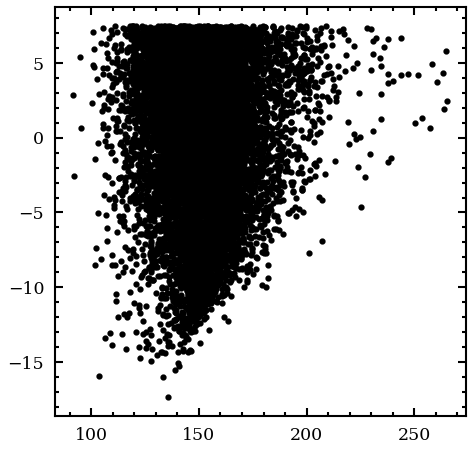

In [199]:
plt.scatter(framework_volumes_10k, framework_energies_10k)
plt.show()

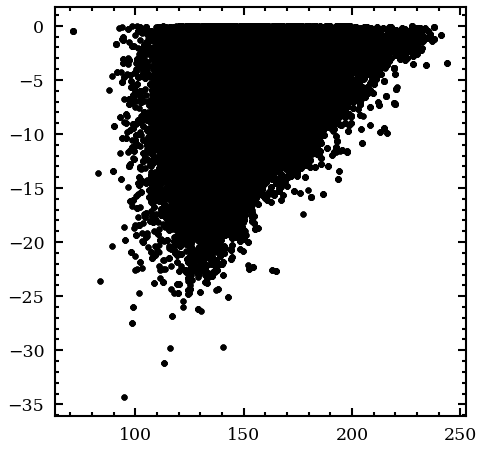

In [200]:
plt.scatter(volumes_10k_6A[energies_10k_6A < 0.0], energies_10k_6A[energies_10k_6A < 0.0])
plt.show()

In [201]:
# Is mean framework energy close to the mean of environment contributions?
m = 0
vdiff = np.zeros(framework_volumes_10k.size)
for idx, i in enumerate(framework_volumes_10k):
    if idx == 6242:
        print '6242: ', (0.75*np.amin(volumes_10k_6A[m:m+n_env])/np.pi)**(1.0/3.0), \
                        (0.75*np.amax(volumes_10k_6A[m:m+n_env])/np.pi)**(1.0/3.0)
    elif idx == 9465:
        print '9465: ', (0.75*np.amin(volumes_10k_6A[m:m+n_env])/np.pi)**(1.0/3.0), \
                        (0.75*np.amax(volumes_10k_6A[m:m+n_env])/np.pi)**(1.0/3.0)
    n_env = np.count_nonzero(structure_idxs_10k == idx)
    vdiff[idx] = i-np.mean(volumes_10k_6A[m:m+n_env])
    m += n_env
print np.amax(np.abs(vdiff))
print np.mean(np.abs(vdiff))
print np.std(vdiff)

6242:  3.288880432486331 3.41515865701305
9465:  3.175609417717556 4.10795054572443
67.1930318985562
2.6936341491211113
4.6599497927741345


In [202]:
# Is mean framework energy close to the mean of environment contributions?
m = 0
ediff = np.zeros(framework_energies_10k.size)
for idx, i in enumerate(framework_energies_10k):
    n_env = np.count_nonzero(structure_idxs_10k == idx)
    ediff[idx] = i-np.mean(energies_10k_6A[m:m+n_env])
    m += n_env
print np.amax(np.abs(ediff))
print np.mean(np.abs(ediff))
print np.std(ediff)

3.4065116305511243
0.29090431619457563
0.40125451756262015


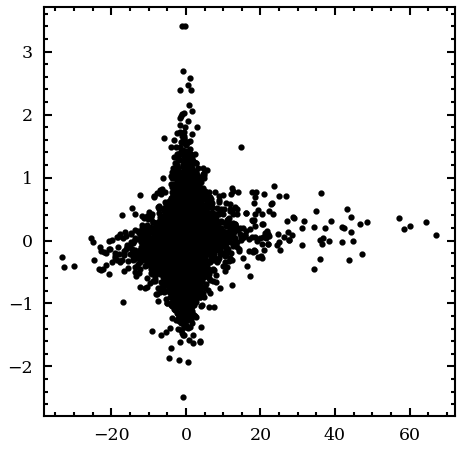

In [203]:
plt.scatter(vdiff, ediff)
plt.show()

In [204]:
# 3.5 A SOAP
n_grid = 40
#vrange = np.linspace(-40, 120, n_grid)
vrange = np.linspace(-120, 360, n_grid)
erange = np.linspace(-75, 150, n_grid)
vv, ee = np.meshgrid(vrange, erange)
pos = np.vstack([vv.ravel(), ee.ravel()])
kde_frameworks_10k = gaussian_kde(np.vstack([framework_volumes_10k, framework_energies_10k]))
z_frameworks_10k = np.reshape(kde_frameworks_10k(pos).T, vv.shape)
kde_environments_10k_3A = gaussian_kde(np.vstack([volumes_10k_3A, energies_10k_3A]))
z_environments_10k_3A = np.reshape(kde_environments_10k_3A(pos).T, vv.shape)

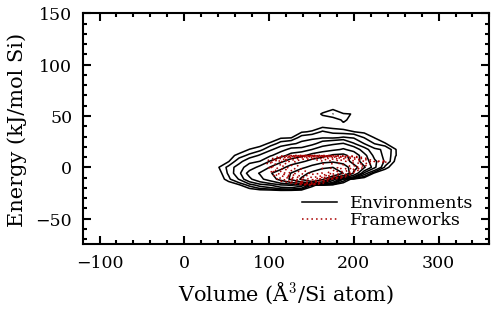

In [205]:
# 3.5 A SOAP
figFramework = plt.figure(figsize=(3.5, 2.0))
axsFramework = figFramework.add_subplot(1, 1, 1)

n_lvls = 10
lvlsEnv = np.logspace(np.log10(z_environments_10k_3A.max()*1.0E-2), 
                      np.log10(z_environments_10k_3A.max()), n_lvls)
lvlsFrame = np.logspace(np.log10(z_frameworks_10k.max()*1.0E-2), 
                        np.log10(z_frameworks_10k.max()), n_lvls)

contour_environments = axsFramework.contour(vv, ee, z_environments_10k_3A,
                                             linestyles='solid', linewidths=0.75, colors=ccycle[0], 
                                             levels=lvlsEnv, zorder=1)
contour_framework = axsFramework.contour(vv, ee, z_frameworks_10k, 
                                          linestyles='dotted', linewidths=0.75, colors=ccycle[1], 
                                          levels=lvlsFrame, zorder=2)

# WARNING: OUTLIERS!
axsFramework.set_ylim([-75, 150])
#axsFramework.set_xlim([-40, 120])
axsFramework.set_xlim([-120, 360])

axsFramework.set_xlabel('Volume ' + ur'(\u00c5$^3$/Si atom)')
axsFramework.set_ylabel('Energy (kJ/mol Si)')

line_env = mpllines.Line2D([0], [0], color=ccycle[0], linewidth=0.75, linestyle='-', label='Environments')
line_frame = mpllines.Line2D([0], [0], color=ccycle[1], linewidth=0.75, linestyle=':', label='Frameworks')

axsFramework.legend(handles=[line_env, line_frame], labelspacing=0, 
                    loc='lower right', bbox_to_anchor=(1.0, 0.0))

plt.show()

In [206]:
# 6.0 A SOAP
n_grid = 40
#vrange = np.linspace(30, 100, n_grid)
vrange = np.linspace(90, 300, n_grid)
erange = np.linspace(-40, 60, n_grid)
vv, ee = np.meshgrid(vrange, erange)
pos = np.vstack([vv.ravel(), ee.ravel()])
kde_frameworks_10k = gaussian_kde(np.vstack([framework_volumes_10k, framework_energies_10k]))
z_frameworks_10k = np.reshape(kde_frameworks_10k(pos).T, vv.shape)
kde_environments_10k_6A = gaussian_kde(np.vstack([volumes_10k_6A, energies_10k_6A]))
z_environments_10k_6A = np.reshape(kde_environments_10k_6A(pos).T, vv.shape)

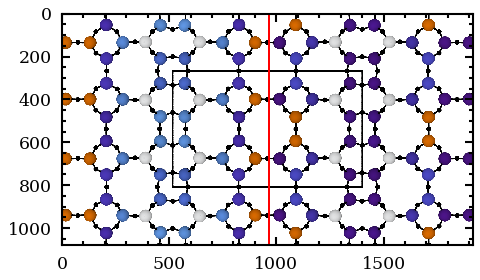

In [207]:
img1 = mplimage.imread('../Raw_Data/tmp2/medE_2x2.png')
plt.imshow(img1)

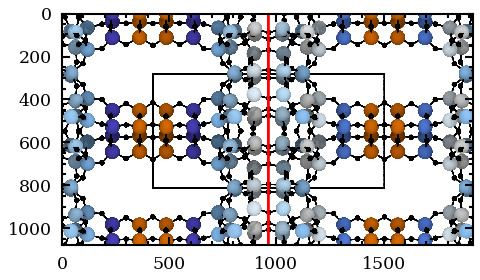

In [208]:
img2 = mplimage.imread('../Raw_Data/tmp2/highVol_2x2.png')
plt.imshow(img2)

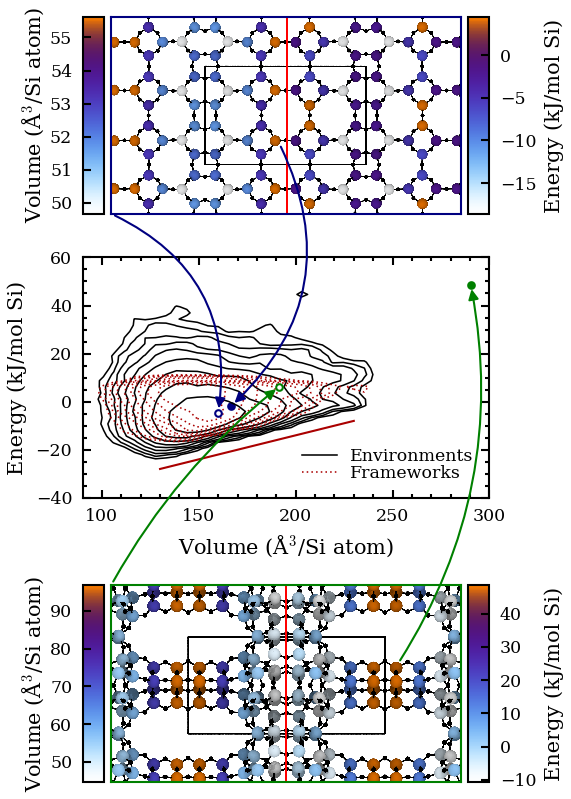

In [209]:
# 6.0 A SOAP
figFramework = plt.figure(figsize=(3.5, 7.0))

gs_data = mpl.gridspec.GridSpec(11, 3, hspace=0.0, wspace=0.0, 
                                height_ratios=(0.1, 0.9, 0.1, 
                                               0.1, 1.1, 0.1, 0.1, 0.1, 
                                               0.1, 0.9, 0.1),
                                width_ratios=(0.06, 1.0, 0.06))

axsFramework = figFramework.add_subplot(gs_data[4, :])

axs1 = figFramework.add_subplot(gs_data[1, 1])
axs2 = figFramework.add_subplot(gs_data[-2, 1])

vaxs1 = figFramework.add_subplot(gs_data[1, 0])
vaxs2 = figFramework.add_subplot(gs_data[-2, 0])

caxs1 = figFramework.add_subplot(gs_data[1, -1])
caxs2 = figFramework.add_subplot(gs_data[-2, -1])

for side in ['top', 'bottom', 'right', 'left']:
    axs1.spines[side].set_color(ccycle[2])
    axs2.spines[side].set_color(ccycle[3])

axs1.imshow(img1, aspect='equal')
axs2.imshow(img2, aspect='equal')

axs1.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False,
                labelleft=False, labelright=False, labelbottom=False, labeltop=False)
axs2.tick_params(axis='both', which='both', left=False, right=False, bottom=False, top=False,
                labelleft=False, labelright=False, labelbottom=False, labeltop=False)


n_lvls = 10
lvlsEnv = np.logspace(np.log10(z_environments_10k_6A.max()*1.0E-2), 
                      np.log10(z_environments_10k_6A.max()), n_lvls)
lvlsFrame = np.logspace(np.log10(z_frameworks_10k.max()*1.0E-2), 
                        np.log10(z_frameworks_10k.max()), n_lvls)

contour_environments = axsFramework.contour(vv, ee, z_environments_10k_6A,
                                             linestyles='solid', linewidths=0.75, colors=ccycle[0], 
                                             levels=lvlsEnv, zorder=2)
contour_framework = axsFramework.contour(vv, ee, z_frameworks_10k, 
                                          linestyles='dotted', linewidths=0.75, colors=ccycle[1], 
                                          levels=lvlsFrame, zorder=3)

dummyx = np.linspace(130, 230, 2)
dummyy = np.linspace(-28, -8, 2)
axsFramework.plot(dummyx, dummyy, linestyle='-', color=ccycle[1])

axsFramework.set_ylim([-40, 60])
#axsFramework.set_xlim([30, 100])
axsFramework.set_xlim([90, 300])

axsFramework.set_xlabel('Volume ' + ur'(\u00c5$^3$/Si atom)')
axsFramework.set_ylabel('Energy (kJ/mol Si)')

line_env = mpllines.Line2D([0], [0], color=ccycle[0], linewidth=0.75, linestyle='-', label='Environments')
line_frame = mpllines.Line2D([0], [0], color=ccycle[1], linewidth=0.75, linestyle=':', label='Frameworks')

axsFramework.legend(handles=[line_env, line_frame], labelspacing=0, 
                    loc='lower right', bbox_to_anchor=(1.0, 0.0))

axsFramework.scatter(volumes_10k_6A[236960], energies_10k_6A[236960], marker='o', s=10, c=ccycle[2])
axsFramework.scatter(volumes_10k_6A[464212], energies_10k_6A[464212], marker='o', s=10, c=ccycle[3])

axsFramework.scatter(framework_volumes_10k[6242], framework_energies_10k[6242], 
                     marker='o', s=10, edgecolor=ccycle[2], facecolor='w', zorder=4)
axsFramework.scatter(framework_volumes_10k[9465], framework_energies_10k[9465], 
                     marker='o', s=10, edgecolor=ccycle[3], facecolor='w', zorder=4)

axs1.annotate('', xy=(volumes_10k_6A[236960], energies_10k_6A[236960]),
              xycoords=axsFramework.transData, 
              xytext=(0.48, 0.36), textcoords=axs1.transAxes,
                      arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=-0.37', color=ccycle[2]))
axs1.annotate('', xy=(framework_volumes_10k[6242], framework_energies_10k[6242]),
              xycoords=axsFramework.transData, 
              xytext=(0.0, 0.0), textcoords=axs1.transAxes,
                      arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=-0.37', color=ccycle[2]))

axs2.annotate('', xy=(volumes_10k_6A[464212], energies_10k_6A[464212]), 
              xycoords=axsFramework.transData, 
              xytext=(0.82, 0.60), textcoords=axs2.transAxes,
              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.2', color=ccycle[3]))
axs2.annotate('', xy=(framework_volumes_10k[9465], framework_energies_10k[9465]), 
              xycoords=axsFramework.transData, 
              xytext=(0.0, 1.0), textcoords=axs2.transAxes,
              arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=-0.1', color=ccycle[3]))

normE1 = mplcolors.Normalize(vmin=-18.5793, vmax=4.43539)
smE1 = mpl.cm.ScalarMappable(norm=normE1, cmap='cbarHot')
smE1.set_array([])
cbE1 = figFramework.colorbar(smE1, cax=caxs1)
cbE1.ax.tick_params(which='minor', right=False)
#cbE1.set_ticks([-16, -12, -8, -4, 0, 4])
cbE1.set_label('Energy (kJ/mol Si)')

normE2 = mplcolors.Normalize(vmin=-10.5835, vmax=48.5417)
smE2 = mpl.cm.ScalarMappable(norm=normE2, cmap='cbarHot')
smE2.set_array([])
cbE2 = figFramework.colorbar(smE2, cax=caxs2)
cbE2.ax.tick_params(which='minor', right=False)
#cbE2.set_ticks([-10, 0, 10, 20, 30, 40, 50])
cbE2.set_label('Energy (kJ/mol Si)')

normV1 = mplcolors.Normalize(vmin=49.672, vmax=55.616)
smV1 = mpl.cm.ScalarMappable(norm=normV1, cmap='cbarHot')
smV1.set_array([])
cbV1 = figFramework.colorbar(smV1, cax=vaxs1)
cbV1.ax.tick_params(which='minor', right=False)
cbV1.ax.tick_params(which='major', left=True, right=False, labelleft=True, labelright=False)
#cbV1.set_ticks([50, 60, 70, 80, 90])
cbV1.set_label('Volume ' + ur'(\u00c5$^3$/Si atom)', labelpad=-45)

normV2 = mplcolors.Normalize(vmin=44.7145, vmax=96.7928)
smV2 = mpl.cm.ScalarMappable(norm=normV2, cmap='cbarHot')
smV2.set_array([])
cbV2 = figFramework.colorbar(smV2, cax=vaxs2)
cbV2.ax.tick_params(which='minor', right=False)
cbV2.ax.tick_params(which='major', left=True, right=False, labelleft=True, labelright=False)
#cbV2.set_ticks([50, 60, 70, 80, 90])
cbV2.set_label('Volume ' + ur'(\u00c5$^3$/Si atom)', labelpad=-45)

plt.savefig('../Results/DEEM_10k/environments-frameworks_6.0_10k.pdf', bbox_inches='tight', dpi=600)

plt.show()

In [210]:
# Linear regression on rings
rings = np.loadtxt('../Processed_Data/DEEM_10k/Rings/Short/Distribution/rings.dat')

In [211]:
# Regression on environment properties
w_env = np.dot(np.linalg.pinv(rings - np.mean(rings, axis=0)), volumes_10k_6A - np.mean(volumes_10k_6A))
print w_env/np.linalg.norm(w_env)

[ 0.00000000e+00  2.50383952e-16  7.70251538e-01  4.18658888e-01
 -2.55492678e-01 -1.93796556e-01 -3.13450261e-01 -6.21745588e-02
 -9.25567341e-02  2.80888768e-02  0.00000000e+00  1.30886263e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


[[  3.         156.50363901  23.14683309]
 [  4.         171.82086866  27.98055735]
 [  5.         157.0076846   23.30249557]
 [  6.         152.23944532  21.48642454]
 [  7.         143.84970627  18.14206696]
 [  8.         156.93893955  21.49445624]
 [  9.         148.27142676  25.36471733]
 [ 10.         157.51200032  23.85758626]
 [ 12.         167.81042276  14.65911549]]
[[ 3.         11.21867302 19.46196488]
 [ 4.          4.55070213 11.27643386]
 [ 5.          0.93153041  9.82656   ]
 [ 6.         -1.30114105  9.99785088]
 [ 7.          1.00287536 10.10909752]
 [ 8.          0.4067577   8.96555934]
 [ 9.          4.51010788 10.49544712]
 [10.          1.90395492  9.19628272]
 [12.          5.17286333  7.08682489]]


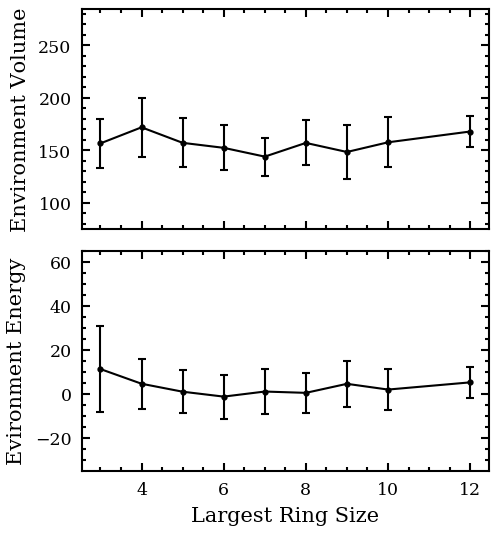

In [212]:
largest_rings = np.zeros(rings.shape[0], dtype=np.int)
for i in range(0, rings.shape[0]):
    largest_rings[i] = np.amax(np.nonzero(rings[i, :])[0])+1
        
min_rings = np.amin(largest_rings)
max_rings = np.amax(largest_rings)
statsV = np.zeros(((max_rings-min_rings+1), 3))
statsE = np.zeros(((max_rings-min_rings+1), 3))

for idx, i in enumerate(range(min_rings, max_rings+1)):
    ringV = volumes_10k_6A[largest_rings == i]
    ringE = energies_10k_6A[largest_rings == i]
    statsV[idx, 0] = i
    statsE[idx, 0] = i
    if ringV.size > 0:
        statsV[idx, 1] = np.mean(ringV)
        statsV[idx, 2] = np.std(ringV)
    if ringE.size > 0:
        statsE[idx, 1] = np.mean(ringE)
        statsE[idx, 2] = np.std(ringE)
        
statsV = np.delete(statsV, 8, axis=0)
statsE = np.delete(statsE, 8, axis=0)
print statsV
print statsE

figRings = plt.figure(figsize=(3.5, 4.0))
axsV = figRings.add_subplot(2, 1, 1)
axsE = figRings.add_subplot(2, 1, 2)

axsV.scatter(statsV[:, 0], statsV[:, 1])
axsV.errorbar(statsV[:, 0], statsV[:, 1], yerr=statsV[:, 2])

axsE.scatter(statsE[:, 0], statsE[:, 1])
axsE.errorbar(statsE[:, 0], statsE[:, 1], yerr=statsE[:, 2])

axsE.set_xlabel('Largest Ring Size')
axsV.set_ylabel('Environment Volume')
axsE.set_ylabel('Evironment Energy')

axsE.set_ylim([-35, 65])
#axsV.set_ylim([25, 95])
axsV.set_ylim([75, 285])
axsV.tick_params(axis='x', labelbottom=False)
figRings.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

In [213]:
# Linear regression on rings
rings = np.loadtxt('../Processed_Data/DEEM_10k/Rings/Short/Binary/rings.dat')

In [214]:
# Regression on environment properties
w_env = np.dot(np.linalg.pinv(rings - np.mean(rings, axis=0)), volumes_10k_6A - np.mean(volumes_10k_6A))
print w_env/np.linalg.norm(w_env)

[ 0.00000000e+00  1.16405515e-17  3.47766799e-01  4.03331166e-01
 -3.32156986e-01 -3.93457948e-01 -5.00142058e-01 -7.35154894e-02
 -2.96925604e-01  4.46463501e-02  0.00000000e+00  3.24869339e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [215]:
# Linear regression on rings
rings = np.loadtxt('../Processed_Data/DEEM_10k/Rings/King/Distribution/rings.dat')

In [216]:
# Regression on environment properties
w_env = np.dot(np.linalg.pinv(rings - np.mean(rings, axis=0)), volumes_10k_6A - np.mean(volumes_10k_6A))
print w_env/np.linalg.norm(w_env)

[ 0.00000000e+00  1.08221022e-16  8.56829466e-01  4.79720831e-01
 -4.56183948e-02 -6.55376804e-02 -1.45229236e-01 -5.48462649e-02
 -3.87528599e-02  8.36717494e-03 -1.14274729e-03 -6.05162866e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [217]:
# Linear regression on rings
rings = np.loadtxt('../Processed_Data/DEEM_10k/Rings/King/Binary/rings.dat')

In [218]:
# Regression on environment properties
w_env = np.dot(np.linalg.pinv(rings - np.mean(rings, axis=0)), volumes_10k_6A - np.mean(volumes_10k_6A))
print w_env/np.linalg.norm(w_env)

[ 0.00000000e+00  3.62175972e-16  5.79865855e-01  6.56238151e-01
 -7.48689695e-02  4.81353563e-02 -3.49155428e-01 -9.46215176e-02
 -7.44746426e-02  1.09376485e-01  9.98052814e-02 -2.58555946e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
